In [2]:
# nltk data download
import nltk

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re

import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from tensorflow.keras.preprocessing.text import Tokenizer

from gensim.matutils import hellinger, jaccard
from gensim.models.word2vec import Word2Vec

tokenizer = TreebankWordTokenizer()
lemmatizer = WordNetLemmatizer()

In [10]:
# class for lemmatization

class LemmatizationWithPOSTagger(object):
    def __init__(self):
        pass
    def get_wordnet_pos(self,treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # As default pos in lemmatization is Noun
            return wordnet.NOUN

    def pos_tag(self,tokens):
        # find the pos tagginf for each tokens [('What', 'WP'), ('can', 'MD'), ('I', 'PRP') ....
        pos_tokens = [nltk.pos_tag(token) for token in tokens]

        # lemmatization using pos tagg   
        # convert into feature set of [('What', 'What', ['WP']), ('can', 'can', ['MD']), ... ie [original WORD, Lemmatized word, POS tag]
        pos_tokens = [ [(word, lemmatizer.lemmatize(word,self.get_wordnet_pos(pos_tag)), [pos_tag]) for (word,pos_tag) in pos] for pos in pos_tokens]
        return pos_tokens

In [11]:
# Load data
df = pd.read_csv('C:/Users/Euisung/Desktop/Artech/Graduation/dataset/dataset_cognitivescience_01_TiAbs.csv', encoding='latin')
df[0:10]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     255 non-null    object 
 1   Abstract  235 non-null    object 
 2   Label     11 non-null     float64
dtypes: float64(1), object(2)
memory usage: 6.1+ KB


In [12]:
# null check & delete
print(df.isnull().sum())
num_label = df['Label'].sum()  # including된 논문 개수

df_nullout = df[['Title', 'Abstract']].dropna().copy() # 파생 dataFrame 메모리 할당
df_nullout['Text'] = df_nullout[['Title', 'Abstract']].apply(lambda x: '. '.join(x), axis=1) # Titel + Abstract 합친 열 생성
df_nullout['Label'] = df['Label']
df_nullout['Label'].fillna(0, inplace=True)
df_nullout.reset_index(drop=True, inplace=True) # 행 index 리셋 (Null로 지운 행이 번호 상 빠져있기 때문)
print(df_nullout)
# print(df_nullout.iloc[215])
indices = pd.Series(df_nullout.index, index=df_nullout['Title'])

texts = df_nullout.get('Text')
texts[0] # doc2vec사용 가능 포멧

Title         0
Abstract     20
Label       244
dtype: int64
                                                 Title  \
0    About the effectiveness of telehealth procedur...   
1    Acceptability of virtual reality interoceptive...   
2    Acute anxiolytic effects of quetiapine during ...   
3    Age-dependent modulation of sensory reweightin...   
4    Allocentric lock in anorexia nervosa: New evid...   
..                                                 ...   
230  VirtualPhobia: A Model for Virtual Therapy of ...   
231  Visualizing ideal self vs. actual self through...   
232  Wii Fit is effective in women with bone loss c...   
233  Working alliance inventory applied to virtual ...   
234  Yohimbine enhancement of exposure therapy for ...   

                                              Abstract  \
0    Use of new technologies for psychological trea...   
1    Interoceptive exposure (IE) is a standard comp...   
2    Anxiety disorders are among the most frequent ...   
3    Older

'About the effectiveness of telehealth procedures in psychological treatments.. Use of new technologies for psychological treatment is currently experiencing considerable growth. From an experimental point of view, the greatest developments have concerned use of virtual reality and online programs. The present study analyzes both types of resources, with a special focus on Internet-based psychological treatment programs. The development of virtual reality has mainly been aimed at treating phobias. This resource has shown similar effectiveness to traditional treatments and even greater clinical efficacy in some cases. Internet-based psychological treatment has had a broader development, although it has been particularly applied to anxiety and depression problems. Systematic reviews and meta-analyses have shown a great heterogeneity of studies; however, some programs have proven to be effective, particularly when compared to a group without treatment and when such programs involve contac

# Preprocessing

In [13]:
paragraphs = []
for text in texts.values:
    paragraphs.append(sent_tokenize(text))
    
paragraphs[0]

['About the effectiveness of telehealth procedures in psychological treatments.. Use of new technologies for psychological treatment is currently experiencing considerable growth.',
 'From an experimental point of view, the greatest developments have concerned use of virtual reality and online programs.',
 'The present study analyzes both types of resources, with a special focus on Internet-based psychological treatment programs.',
 'The development of virtual reality has mainly been aimed at treating phobias.',
 'This resource has shown similar effectiveness to traditional treatments and even greater clinical efficacy in some cases.',
 'Internet-based psychological treatment has had a broader development, although it has been particularly applied to anxiety and depression problems.',
 'Systematic reviews and meta-analyses have shown a great heterogeneity of studies; however, some programs have proven to be effective, particularly when compared to a group without treatment and when suc

In [14]:
# stop-word custom

stop_words = stopwords.words('english')
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https',
    'et', 'al', 'figure', 'rights', 'reserved', 'permission', 'used',
    'using', 'license', 'fig', 'fig.', 'al.', 'elsevier', 'pmc', 'www'
]

for w in custom_stop_words:
    if w not in stop_words:
        stop_words.append(w)

In [15]:
lemmatization_using_pos_tagger = LemmatizationWithPOSTagger()

preprocessed_text = []
for i in range(0, len(texts)):
    line = []
    for string in paragraphs[i]:
        normalized_text = re.sub(r"[^a-z]+", " ", string.lower())                 # 텍스트 정규화. 특수문자 제거, 소문자화
        if normalized_text == " " : continue
        tokenized_text = tokenizer.tokenize(normalized_text)                           # 텍스트 토큰화
        stopped_text = [token for token in tokenized_text if token not in stop_words]  # 불용어처리
        under2_text = [token for token in stopped_text if (len(token)>2 or ('vr' in token))]
        line.append(under2_text)
    preprocessed_text.append(line)

lemmatized_pos_text = []
for i in range(0, len(preprocessed_text)):
    lemmatized_pos_text.append(lemmatization_using_pos_tagger.pos_tag(preprocessed_text[i]))        # pos_tag 방식으로 표제어추출
lemmatized_pos_text[0][0][0]
# len(lemmatized_pos_text)

('effectiveness', 'effectiveness', ['NN'])

In [16]:
token_list = []
for i in range(0, len(lemmatized_pos_text)):
    line = []
    for j in range(0, len(lemmatized_pos_text[i])):
        token = []
        for k in range(0, len(lemmatized_pos_text[i][j])):
            if (len(lemmatized_pos_text[i][j][k][1])>2 or ('vr' in lemmatized_pos_text[i][j][k][1])):
#                 print(lemmatized_pos_text[i][j][k][1])
                token.append(lemmatized_pos_text[i][j][k][1])
        line.append(token)
    token_list.append(line)

token_list[0]
len(token_list)

# token_list -> 정규화, 토큰화, 불용어, 표제어추출까지 됨

235

In [17]:
token_forTF = []
for i in range(0, len(token_list)):
    line = []
    for j in range(0, len(token_list[i])):
        line.append(" ".join(token_list[i][j]))
    token_forTF.append(" ".join(line))
token_forTF  # list 형식, 한 셀에 패러그래프 그대로 들어가있음

token_word = [tokenizer.tokenize(token) for token in token_forTF]  # list 형식, 한 셀에 패러그래프 token화 된 거 들어 있음
# token_word
# token_forTF
len(token_forTF)

235

In [18]:
tfidfVector = TfidfVectorizer(stop_words=None, ngram_range=(1,1)) # ngram_range: (1,1) unigram, (2,2) bigram
tfidf_matrix = tfidfVector.fit_transform(token_forTF)
tfidf_matrix

<235x3585 sparse matrix of type '<class 'numpy.float64'>'
	with 19534 stored elements in Compressed Sparse Row format>

## Parser -> scispacy 기반

In [19]:
import string

punctuations = string.punctuation

In [20]:
from tqdm import tqdm
import scispacy
import spacy
import en_core_sci_lg

parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 700000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [21]:
tqdm.pandas()
df_nullout['Preprocessed_text'] = df_nullout['Text'].progress_apply(spacy_tokenizer)

C:\Users\Euisung\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 235/235 [00:04<00:00, 47.17it/s]


count    235.000000
mean     209.157447
std       81.317915
min       45.000000
25%      161.000000
50%      207.000000
75%      248.500000
max      805.000000
Name: abstract_word_count, dtype: float64

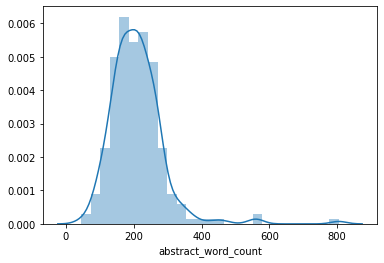

In [22]:
import seaborn as sns

df_nullout['abstract_word_count'] = df_nullout['Text'].apply(lambda x: len(x.strip().split()))

sns.distplot(df_nullout['abstract_word_count'])
df_nullout['abstract_word_count'].describe()

In [23]:
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    
    global vocabs
    vocabs = [vocab for vocab, idx in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])]
    return X

In [24]:
scispacy_text = df_nullout['Preprocessed_text'].values
X_t = vectorize(scispacy_text, 300)
X_t

<235x300 sparse matrix of type '<class 'numpy.float64'>'
	with 10452 stored elements in Compressed Sparse Row format>

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X_t.toarray())
X_reduced.shape # array type

X_csr = csr_matrix(X_reduced) # sparse matrix type

# scaler = StandardScaler()
# scaler.fit_transform(X_reduced)

In [121]:
from soyclustering import SphericalKMeans

spherical_kmeans = SphericalKMeans(
    n_clusters = 10,
    max_iter=10,
    verbose=1,
    init='similar_cut',
    sparsity = 'minimum_df',
    minimum_df_factor=0.05,
    random_state=21)

_1st_k = spherical_kmeans.n_clusters  # 1st step의 k값 저장
labels = spherical_kmeans.fit_predict(X_t)

initialization_time=0.011966 sec, sparsity=0.126
n_iter=1, changed=199, inertia=165.508, iter_time=0.013 sec, sparsity=0.237
n_iter=2, changed=25, inertia=131.297, iter_time=0.011 sec, sparsity=0.232
n_iter=3, changed=12, inertia=128.973, iter_time=0.013 sec, sparsity=0.223
n_iter=4, changed=11, inertia=127.777, iter_time=0.013 sec, sparsity=0.217
n_iter=5, changed=5, inertia=127.020, iter_time=0.011 sec, sparsity=0.214
n_iter=6, changed=1, inertia=126.740, iter_time=0.011 sec, sparsity=0.213
Early converged.


In [122]:
df_nullout['y'] = labels
# print(len(df_nullout[df_nullout['y'].isin(['1'])]))
is_Label = df_nullout[df_nullout['Label'].isin(['1'])]
sub_df = pd.DataFrame(is_Label)

print('총 문서 수 : %d' % len(df_nullout))
print('예측값 분포')
print(df_nullout['y'].value_counts())
print('Label=1, 예측값 분포')
print(sub_df['y'].value_counts())
# df_nullout[df_nullout['Label'].isin(['1'])]
# print(df_nullout[df_nullout['y'].isin(['2'])])

총 문서 수 : 235
예측값 분포
1    50
2    49
0    37
7    28
8    17
5    17
3    12
4    11
9     7
6     7
Name: y, dtype: int64
Label=1, 예측값 분포
1    11
Name: y, dtype: int64


In [123]:
from soyclustering import proportion_keywords

centers = spherical_kmeans.cluster_centers_
labels = spherical_kmeans.labels_

keywords = proportion_keywords(
    centers,
    labels, 
    index2word=vocabs, stopwords = stop_words)

In [124]:
cluster_indices = []
for cluster_idx, keyword in enumerate(keywords):
    keyword = ' '.join([w for w,_ in keyword])
    if 'therap' in keyword:
        print('cluster#{} : {}\n'.format(cluster_idx, keyword))
        cluster_indices.append(cluster_idx)
#     print('cluster#{} : {}\n'.format(cluster_idx, keyword))
cluster_indices

cluster#1 : challenge value people activity implementation test donation computer expectancy protocol cortex randomize six experience psychophysiological reaction control expose visual combine eight treatment treat music addition psychological frequency avatar good particularly follow non analysis situation response potential dialogue train significant end measure post life psychotic great component result little technology report four scenario common reduce conclusion blood therapeutic symptom several exposure interaction aim traditional paper primary tension participants long problem conversation time ie consider yohimbine decrease fly relevant session vr week patient although cbt overall improve home need level effective complete high efficacy spider

cluster#2 : heart alternative current base maintain prior integrate intervention objective cognitive effect prefrontal criterium due results global activation new 20 stimulus vrcbt therapy free posttreatment panic vivo randomly investi

[1, 2, 6, 8]

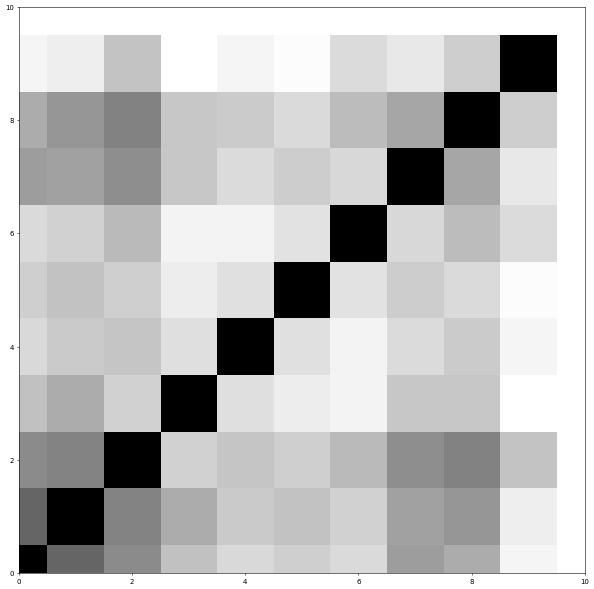

In [125]:
from soyclustering import visualize_pairwise_distance

# visualize pairwise distance matrix
fig = visualize_pairwise_distance(centers, max_dist=.5, sort=True)

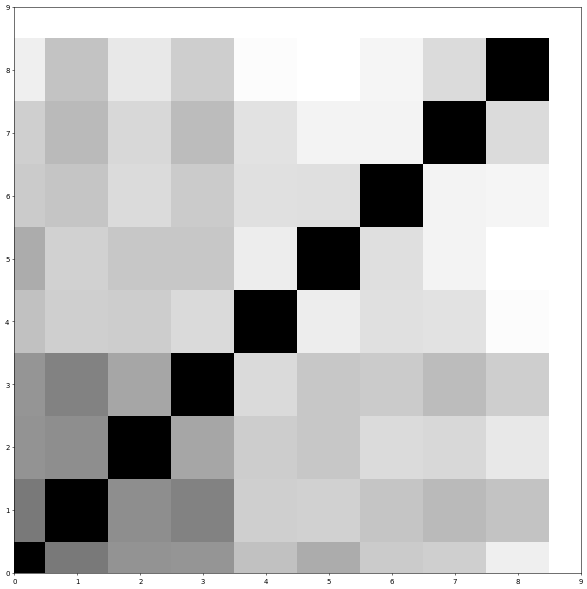

In [126]:
from soyclustering import merge_close_clusters

group_centers, groups = merge_close_clusters(centers, labels, max_dist=.5)
fig = visualize_pairwise_distance(group_centers, max_dist=.7, sort=True)

In [127]:
for group in groups:
    print(group)

[1, 0]
[2]
[7]
[5]
[8]
[3]
[4]
[6]
[9]


## 2nd step-wise clustering

In [128]:
cluster_list = {1,0}
is_stepwise = df_nullout['y'].isin(cluster_list)
is_stepwise
df_second_step = df_nullout[is_stepwise].reset_index().drop('index', axis=1)
df_second_step.shape

(87, 7)

In [129]:
scispacy_text_2 = df_second_step['Preprocessed_text'].values
X_t2 = vectorize(scispacy_text_2, 300)
X_t2.shape

(87, 300)

In [130]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=0.95, random_state=42)
X_reduced2= pca.fit_transform(X_t2.toarray())
X_reduced2.shape

# scaler = StandardScaler()
# scaler.fit_transform(X_reduced)

(87, 68)

In [168]:

spherical_kmeans = SphericalKMeans(
    n_clusters = 7,
    max_iter=10,
    verbose=1,
    init='similar_cut',
    sparsity = 'minimum_df',
    minimum_df_factor=0.05,
    random_state=21)

labels = spherical_kmeans.fit_predict(X_t2)

initialization_time=0.007982 sec, sparsity=0.17
n_iter=1, changed=66, inertia=59.480, iter_time=0.008 sec, sparsity=0.15
n_iter=2, changed=8, inertia=46.660, iter_time=0.006 sec, sparsity=0.141
n_iter=3, changed=4, inertia=46.016, iter_time=0.006 sec, sparsity=0.142
n_iter=4, changed=1, inertia=45.443, iter_time=0.007 sec, sparsity=0.144
Early converged.


In [169]:
df_second_step['y'] = labels
# print(len(df_nullout[df_nullout['y'].isin(['1'])]))
is_Label = df_second_step[df_second_step['Label'].isin(['1'])]
sub_df = pd.DataFrame(is_Label)

print('총 문서 수 : %d' % len(df_second_step))
print('예측값 분포')
print(df_second_step['y'].value_counts())
print('Label=1, 예측값 분포')
print(sub_df['y'].value_counts())
# df_second_step[df_second_step['Label'].isin(['1'])]
# print(df_nullout[df_nullout['y'].isin(['2'])])

총 문서 수 : 87
예측값 분포
3    21
0    21
2    18
4    10
1     9
6     4
5     4
Name: y, dtype: int64
Label=1, 예측값 분포
2    6
3    5
Name: y, dtype: int64


In [170]:
#2nd

centers = spherical_kmeans.cluster_centers_
labels = spherical_kmeans.labels_

keywords = proportion_keywords(
    centers,
    labels, 
    index2word=vocabs, stopwords = stop_words)

cluster_indices = []
for cluster_idx, keyword in enumerate(keywords):
    keyword = ' '.join([w for w,_ in keyword])
    if 'therap' in keyword:
        print('cluster#{} : {}\n'.format(cluster_idx, keyword))
        cluster_indices.append(cluster_idx)
#     print('cluster#{} : {}\n'.format(cluster_idx, keyword))
cluster_indices

cluster#0 : technology improvement design rating individual cbt low system randomize panic social furthermore two iv four participant future self follow strategy therapist aim guideline prior moderate hf therapy cycloserine integrate evaluation difference patient either parent end systematic dropout noradrenaline receive socially conversation background vre report six analysis little sample diagnose vivo vret visual indicate subjective relate train participants stimulus vrcbt outcome



[0]

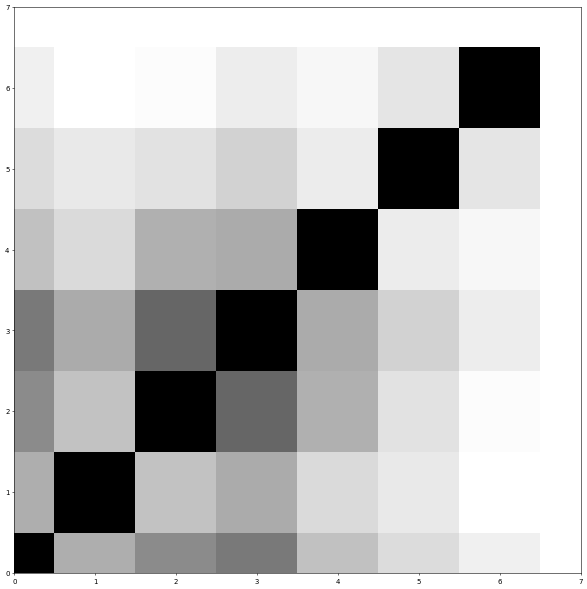

In [171]:
from soyclustering import visualize_pairwise_distance

# visualize pairwise distance matrix
fig = visualize_pairwise_distance(centers, max_dist=.7, sort=True)

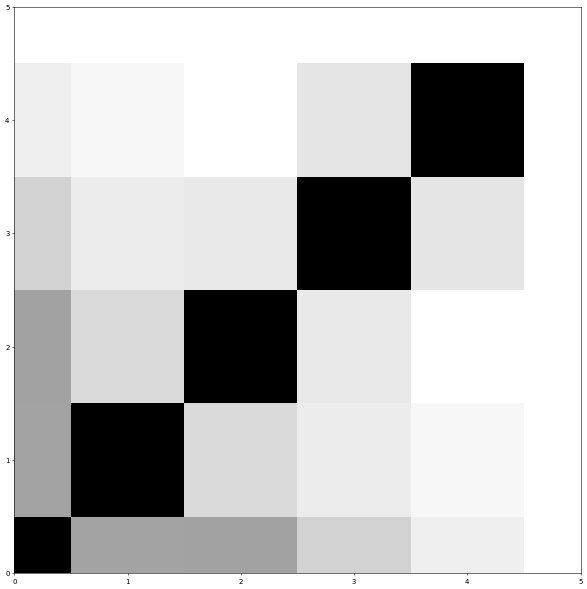

In [174]:
from soyclustering import merge_close_clusters

group_centers, groups = merge_close_clusters(centers, labels, max_dist=.5)
fig = visualize_pairwise_distance(group_centers, max_dist=.7, sort=True)

In [175]:
for group in groups:
    print(group)

[0, 3, 2]
[4]
[1]
[5]
[6]


## 3rd step-wise clustering

In [176]:
cluster_list = {0,2,3}
is_stepwise = df_second_step['y'].isin(cluster_list)
is_stepwise
df_third_step = df_second_step[is_stepwise].reset_index().drop('index', axis=1)
df_third_step.shape

(60, 7)

In [177]:
scispacy_text_3 = df_third_step['Preprocessed_text'].values
X_t3 = vectorize(scispacy_text_3, 300)
X_t3.shape

(60, 300)

In [178]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=0.95, random_state=42)
X_reduced3= pca.fit_transform(X_t3.toarray())
X_reduced3.shape

# scaler = StandardScaler()
# scaler.fit_transform(X_reduced)

(60, 49)

In [185]:

spherical_kmeans = SphericalKMeans(
    n_clusters = 5,
    max_iter=10,
    verbose=1,
    init='similar_cut',
    sparsity = 'minimum_df',
    minimum_df_factor=0.05,
    random_state=23)

labels = spherical_kmeans.fit_predict(X_t3)

initialization_time=0.004987 sec, sparsity=0.193
n_iter=1, changed=47, inertia=39.487, iter_time=0.007 sec, sparsity=0.149
n_iter=2, changed=0, inertia=32.420, iter_time=0.007 sec, sparsity=0.149
Early converged.


In [186]:
df_third_step['y'] = labels
# print(len(df_nullout[df_nullout['y'].isin(['1'])]))
is_Label = df_third_step[df_third_step['Label'].isin(['1'])]
sub_df = pd.DataFrame(is_Label)

print('총 문서 수 : %d' % len(df_third_step))
print('예측값 분포')
print(df_third_step['y'].value_counts())
print('Label=1, 예측값 분포')
print(sub_df['y'].value_counts())
# df_third_step[df_third_step['Label'].isin(['1'])]
# print(df_nullout[df_nullout['y'].isin(['2'])])

총 문서 수 : 60
예측값 분포
1    34
0    13
4     5
2     5
3     3
Name: y, dtype: int64
Label=1, 예측값 분포
1    5
0    4
4    2
Name: y, dtype: int64


In [187]:
#3rd

centers = spherical_kmeans.cluster_centers_
labels = spherical_kmeans.labels_

keywords = proportion_keywords(
    centers,
    labels, 
    index2word=vocabs, stopwords = stop_words)

cluster_indices = []
for cluster_idx, keyword in enumerate(keywords):
    keyword = ' '.join([w for w,_ in keyword])
    if 'therap' in keyword:
#         print('cluster#{} : {}\n'.format(cluster_idx, keyword))
        cluster_indices.append(cluster_idx)
    print('cluster#{} : {}\n'.format(cluster_idx, keyword))
cluster_indices

cluster#0 : combine preference psychotic fly three also home computer desensitization reactivation regard stimulus prior sample phobic agoraphobia improvement quality symptom condition vret high flight post behavioral cognitive two group much rate level therapist design show based use participant month study follow system treatment patient effect session therapy fear exposure

cluster#1 : social phobia control dialogue research trial measure clinical may effective placebo specific evidence paper technique evaluation one efficacy results improve interaction alliance life work spider result situation people year little report negative yohimbine psychophysiological participants support mindfulness 2012 self however compare conduct vre include sad difference feedback cortisol significant time acute individual intervention experience treat literature old datum yoh pre vrcbt approach speech socially although low heart potential program list process scale real significantly patients investiga

[0, 4]

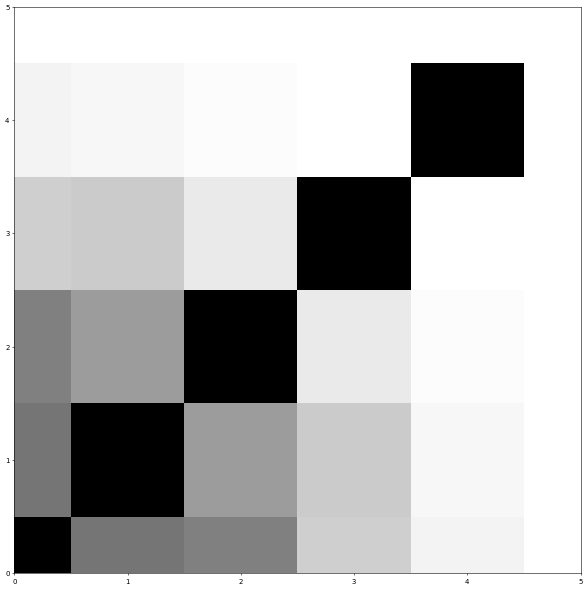

In [188]:
from soyclustering import visualize_pairwise_distance

# visualize pairwise distance matrix
fig = visualize_pairwise_distance(centers, max_dist=.7, sort=True)

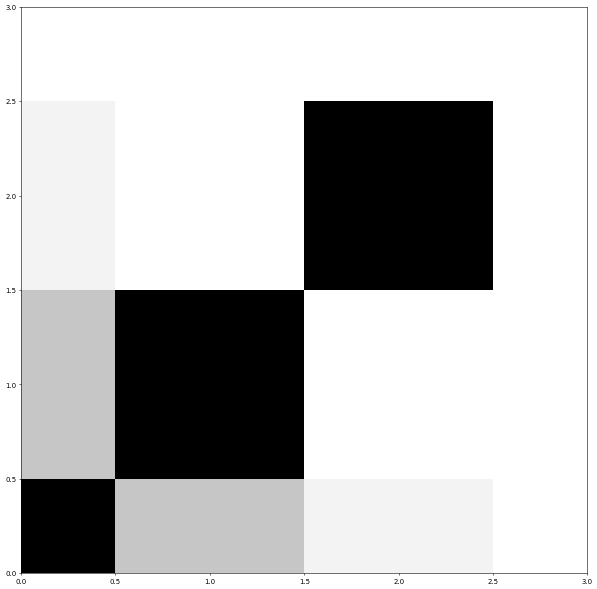

In [192]:
from soyclustering import merge_close_clusters

group_centers, groups = merge_close_clusters(centers, labels, max_dist=.6)
fig = visualize_pairwise_distance(group_centers, max_dist=.7, sort=True)

In [193]:
for group in groups:
    print(group)

[1, 0, 4]
[2]
[3]


## 4th step-wise clustering

In [381]:
cluster_list = {2,3,6,0,1}
is_stepwise = df_third_step['y'].isin(cluster_list)
is_stepwise
df_fourth_step = df_third_step[is_stepwise].reset_index().drop('index', axis=1)
df_fourth_step.shape

(61, 7)

In [382]:
scispacy_text_4 = df_fourth_step['Preprocessed_text'].values
X_t4 = vectorize(scispacy_text_4, 300)
X_t4.shape

(61, 300)

In [383]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=0.95, random_state=42)
X_reduced4= pca.fit_transform(X_t4.toarray())
X_reduced4.shape

# scaler = StandardScaler()
# scaler.fit_transform(X_reduced)

(61, 50)

In [384]:

spherical_kmeans = SphericalKMeans(
    n_clusters = 5,
    max_iter=10,
    verbose=1,
    init='similar_cut',
    sparsity = 'minimum_df',
    minimum_df_factor=0.05,
    random_state=21)

labels = spherical_kmeans.fit_predict(X_t4)

initialization_time=0.004988 sec, sparsity=0.154
n_iter=1, changed=58, inertia=40.853, iter_time=0.004 sec, sparsity=0.169
n_iter=2, changed=2, inertia=32.065, iter_time=0.004 sec, sparsity=0.171
n_iter=3, changed=0, inertia=31.848, iter_time=0.004 sec, sparsity=0.171
Early converged.


In [385]:
df_fourth_step['y'] = labels
# print(len(df_nullout[df_nullout['y'].isin(['1'])]))
is_Label = df_fourth_step[df_fourth_step['Label'].isin(['1'])]
sub_df = pd.DataFrame(is_Label)

print('총 문서 수 : %d' % len(df_fourth_step))
print('예측값 분포')
print(df_fourth_step['y'].value_counts())
print('Label=1, 예측값 분포')
print(sub_df['y'].value_counts())
# df_fourth_step[df_fourth_step['Label'].isin(['1'])]
# print(df_nullout[df_nullout['y'].isin(['2'])])

총 문서 수 : 61
예측값 분포
1    27
2    25
4     5
0     3
3     1
Name: y, dtype: int64
Label=1, 예측값 분포
2    9
4    2
Name: y, dtype: int64


In [386]:
#4th

centers = spherical_kmeans.cluster_centers_
labels = spherical_kmeans.labels_

keywords = proportion_keywords(
    centers,
    labels, 
    index2word=vocabs, stopwords = stop_words)

cluster_indices = []
for cluster_idx, keyword in enumerate(keywords):
    keyword = ' '.join([w for w,_ in keyword])
    if 'therap' in keyword:
#         print('cluster#{} : {}\n'.format(cluster_idx, keyword))
        cluster_indices.append(cluster_idx)
    print('cluster#{} : {}\n'.format(cluster_idx, keyword))
cluster_indices

cluster#0 : ar wai framework var exposition user previous application work system environment use vr

cluster#1 : itbs much approach psychological create different treat software tool technique scenario psychophysiological also paper emotional little response 2016 present design method make problem traumatic natural addition involve cost self computer therapeutic investigate form allow situation provide support life useful case since effectiveness behavioural tsst new model enhance need successfully expose experience real stress world help technology may reaction various people traditional environment vr panic include work use disorder spider virtual patient one research reality phobia two effective efficacy anxiety

cluster#2 : social vret follow vivo trial outcome dialogue randomize three month report quality term behavior difference sleep scale results change speech condition context based vrcbt yohimbine list test post expectancy low significantly time end assign avatar finding pub

[1, 2, 4]

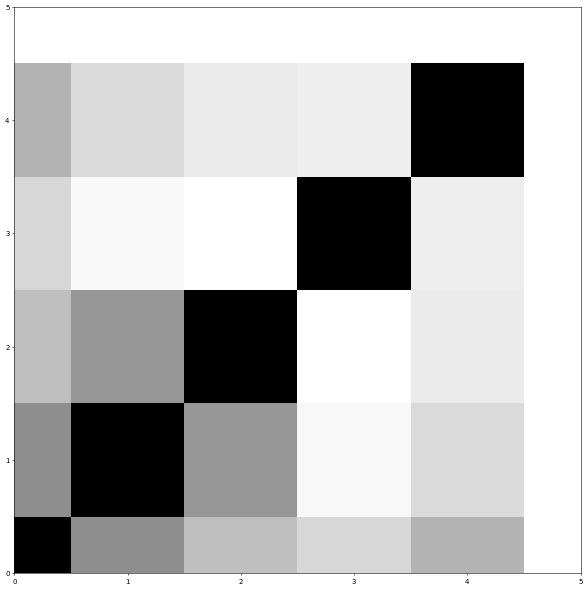

In [387]:
from soyclustering import visualize_pairwise_distance

# visualize pairwise distance matrix
fig = visualize_pairwise_distance(centers, max_dist=.7, sort=True)

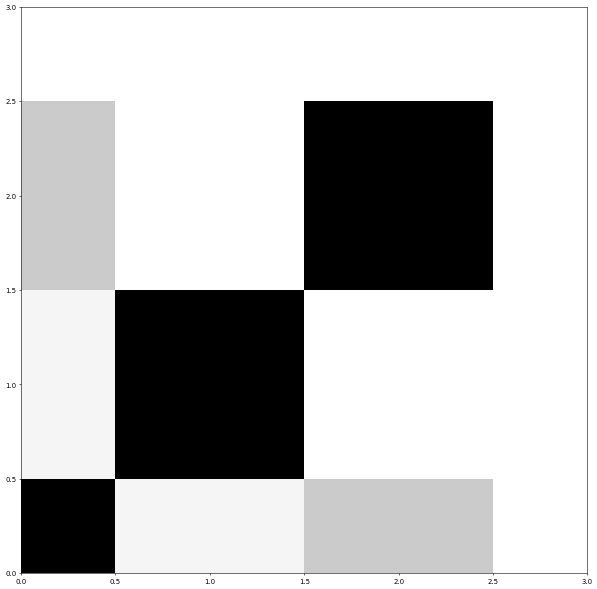

In [392]:
from soyclustering import merge_close_clusters

group_centers, groups = merge_close_clusters(centers, labels, max_dist=.7)
fig = visualize_pairwise_distance(group_centers, max_dist=.7, sort=True)

In [393]:
for group in groups:
    print(group)

[1, 2, 4]
[0]
[3]


## 5th step-wise clustering

In [394]:
cluster_list = {1,2,4}
is_stepwise = df_fourth_step['y'].isin(cluster_list)
is_stepwise
df_fifth_step = df_fourth_step[is_stepwise].reset_index().drop('index', axis=1)
df_fifth_step.shape

(57, 7)

In [395]:
scispacy_text_5 = df_fifth_step['Preprocessed_text'].values
X_t5 = vectorize(scispacy_text_5, 300)
X_t5.shape

(57, 300)

In [396]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=0.95, random_state=42)
X_reduced5= pca.fit_transform(X_t5.toarray())
X_reduced5.shape

# scaler = StandardScaler()
# scaler.fit_transform(X_reduced)

(57, 47)

In [397]:

spherical_kmeans = SphericalKMeans(
    n_clusters = 5,
    max_iter=10,
    verbose=1,
    init='similar_cut',
    sparsity = 'minimum_df',
    minimum_df_factor=0.05,
    random_state=21)

labels = spherical_kmeans.fit_predict(X_t5)

initialization_time=0.005983 sec, sparsity=0.169
n_iter=1, changed=48, inertia=39.370, iter_time=0.006 sec, sparsity=0.184
n_iter=2, changed=4, inertia=28.940, iter_time=0.004 sec, sparsity=0.182
n_iter=3, changed=1, inertia=28.483, iter_time=0.006 sec, sparsity=0.181
Early converged.


In [398]:
df_fifth_step['y'] = labels
# print(len(df_nullout[df_nullout['y'].isin(['1'])]))
is_Label = df_fifth_step[df_fifth_step['Label'].isin(['1'])]
sub_df = pd.DataFrame(is_Label)

print('총 문서 수 : %d' % len(df_fifth_step))
print('예측값 분포')
print(df_fifth_step['y'].value_counts())
print('Label=1, 예측값 분포')
print(sub_df['y'].value_counts())
# df_fifth_step[df_fifth_step['Label'].isin(['1'])]
# print(df_nullout[df_nullout['y'].isin(['2'])])

총 문서 수 : 57
예측값 분포
1    24
2    20
0     7
4     5
3     1
Name: y, dtype: int64
Label=1, 예측값 분포
1    10
4     1
Name: y, dtype: int64


In [399]:
#5th

centers = spherical_kmeans.cluster_centers_
labels = spherical_kmeans.labels_

keywords = proportion_keywords(
    centers,
    labels, 
    index2word=vocabs, stopwords = stop_words)

cluster_indices = []
for cluster_idx, keyword in enumerate(keywords):
    keyword = ' '.join([w for w,_ in keyword])
    if 'therap' in keyword:
#         print('cluster#{} : {}\n'.format(cluster_idx, keyword))
        cluster_indices.append(cluster_idx)
    print('cluster#{} : {}\n'.format(cluster_idx, keyword))
cluster_indices

cluster#0 : itbs psychophysiological sleep memory multiple beneficial reactivation context prior cortisol reaction test spider effect term fear follow vivo session study group vr exposure phobia anxiety treatment

cluster#1 : cbt cognitive behavioral flight measure combine three outcome two efficacy month improvement difference fly desensitization one compare panic post condition result behavior ie list scale results year end therapeutic yohimbine vrcbt case include expectancy involve rate pre little imaginal wait assign new public great show report randomize trial approach reduce traditional change clinical participant individual expectation high agoraphobia group session social vivo follow effective vret control treatment term fear significant level exposure interaction patient therapy anxiety

cluster#2 : world help experience stress real create software psychological tool paper different computer vres technology application response emotional similar various ethical people 2016 tec

[1, 2, 4]

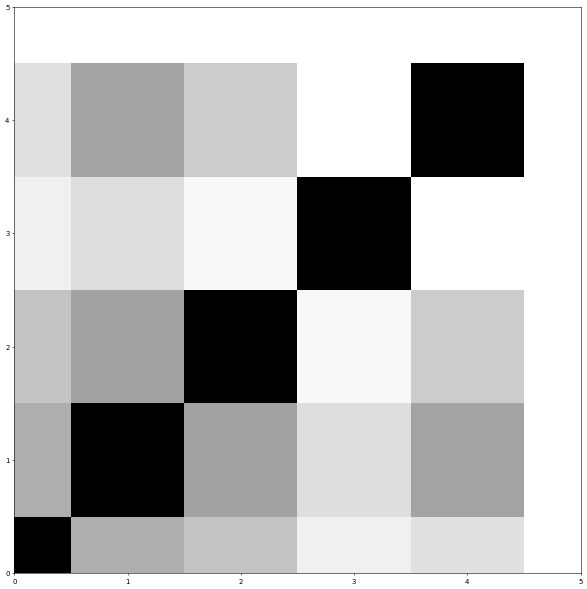

In [400]:
from soyclustering import visualize_pairwise_distance

# visualize pairwise distance matrix
fig = visualize_pairwise_distance(centers, max_dist=.7, sort=True)

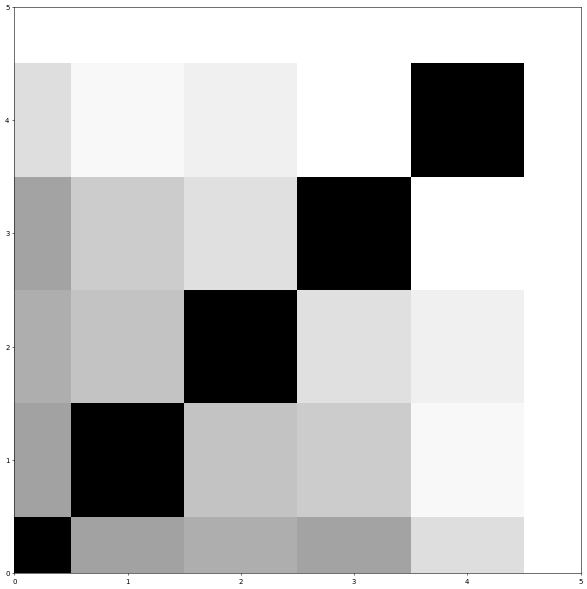

In [409]:
from soyclustering import merge_close_clusters

group_centers, groups = merge_close_clusters(centers, labels, max_dist=.5)
fig = visualize_pairwise_distance(group_centers, max_dist=.7, sort=True)

In [410]:
for group in groups:
    print(group)

[1]
[2]
[0]
[4]
[3]


In [327]:
df_final_merge = pd.DataFrame(df_fifth_step)

df_final_merge.loc[df_final_merge['y']==1, 'y'] = 'merge'
df_final_merge.loc[df_final_merge['y']==3, 'y'] = 'merge'
    
# print(len(df_nullout[df_nullout['y'].isin(['1'])]))
is_Label = df_final_merge[df_final_merge['Label'].isin(['1'])]
sub_df = pd.DataFrame(is_Label)

print('총 문서 수 : %d' % len(df_final_merge))
print('예측값 분포')
print(df_final_merge['y'].value_counts())
print('Label=1, 예측값 분포')
print(sub_df['y'].value_counts())
df_final_merge[df_final_merge['Label'].isin(['1'])]
# print(df_nullout[df_nullout['y'].isin(['2'])])

총 문서 수 : 85
예측값 분포
merge    61
4        16
2         4
0         4
Name: y, dtype: int64
Label=1, 예측값 분포
merge    11
Name: y, dtype: int64


,Title,Abstract,Text,Label,Preprocessed_text,abstract_word_count,y
8,Cognitive-behavioral treatment and antidepress...,In this study we compared the efficacy of virt...,Cognitive-behavioral treatment and antidepress...,1.0,cognitive-behavioral treatment antidepressant ...,177,merge
9,The combined use of virtual reality exposure i...,Introduction. This study compares the differen...,The combined use of virtual reality exposure i...,1.0,combine use virtual reality exposure treatment...,145,merge
10,A controlled study of agoraphobia and the inde...,OBJECTIVES: Past controlled clinical trials ce...,A controlled study of agoraphobia and the inde...,1.0,control study agoraphobia independent effect v...,163,merge
18,Effectiveness of cognitive behavioral therapy ...,The purpose of the research was to compare the...,Effectiveness of cognitive behavioral therapy ...,1.0,effectiveness cognitive behavioral therapy int...,207,merge
30,Exposure to virtual social interactions in the...,This randomized controlled trial investigated ...,Exposure to virtual social interactions in the...,1.0,exposure virtual social interaction treatment ...,224,merge
40,In Vivo versus augmented reality exposure in t...,Although in vivo exposure is the treatment of ...,In Vivo versus augmented reality exposure in t...,1.0,vivo versus augment reality exposure treatment...,284,merge
47,One session treatment of cognitive and behavio...,This randomized clinical trial aimed to invest...,One session treatment of cognitive and behavio...,1.0,one session treatment cognitive behavioral the...,160,merge
72,Virtual reality compared with in vivo exposure...,BackgroundPeople with social anxiety disorder ...,Virtual reality compared with in vivo exposure...,1.0,virtual reality compare vivo exposure treatmen...,216,merge
77,Virtual reality exposure therapy does not prov...,Background: A number of studies have demonstra...,Virtual reality exposure therapy does not prov...,1.0,virtual reality exposure therapy doe provide a...,271,merge
78,Virtual reality exposure therapy for social an...,OBJECTIVE: This is the first randomized trial ...,Virtual reality exposure therapy for social an...,1.0,virtual reality exposure therapy social anxiet...,255,merge


In [263]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

k = 8
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df_nullout['y'] = y_pred
# print(len(df_nullout[df_nullout['y'].isin(['1'])]))
is_Label = df_nullout[df_nullout['Label'].isin(['1'])]
sub_df = pd.DataFrame(is_Label)

print('총 문서 수 : %d' % len(df_nullout))
print('예측값 분포')
print(df_nullout['y'].value_counts())
print('Label=1, 예측값 분포')
print(sub_df['y'].value_counts())
df_nullout[df_nullout['Label'].isin(['1'])]
# print(df_nullout[df_nullout['y'].isin(['2'])])

총 문서 수 : 274
예측값 분포
1    69
5    66
3    44
4    43
2    25
6    13
0     8
7     6
Name: y, dtype: int64
Label=1, 예측값 분포
5    18
2     3
1     3
4     2
Name: y, dtype: int64


,Title,Abstract,Text,Label,Preprocessed_text,abstract_word_count,y
21,Beta-Band Functional Connectivity is Reorganiz...,Physical and cognitive idleness constitute sig...,Beta-Band Functional Connectivity is Reorganiz...,1.0,beta-band functional connectivity reorganized ...,251,5
34,Cognitive and Neural Effects of Vision-Based S...,Objectives To examine the cognitive and neural...,Cognitive and Neural Effects of Vision-Based S...,1.0,cognitive neural effects vision-based speed-of...,264,5
39,Cognitive training changes hippocampal functio...,A randomized pilot experiment examined the neu...,Cognitive training changes hippocampal functio...,1.0,cognitive train change hippocampal function mi...,110,5
41,Cognitive training program to improve working ...,Objectives: Deficits in working memory (WM) ar...,Cognitive training program to improve working ...,1.0,cognitive train program improve work memory ol...,275,5
42,Cognitive Training Using a Novel Memory Game o...,Background: Cognitive training is effective in...,Cognitive Training Using a Novel Memory Game o...,1.0,cognitive training novel memory game ipad pati...,280,5
48,Comparing three methods of computerised cognit...,Cognitive rehabilitation for mild cognitive im...,Comparing three methods of computerised cognit...,1.0,comparing three method computerise cognitive t...,221,5
50,Comparison of Two Cognitive Training Programs ...,The aim of the current study was to compare th...,Comparison of Two Cognitive Training Programs ...,1.0,comparison two cognitive training programs eff...,177,5
56,Computer-based cognitive training for mild cog...,"We performed a pilot randomized, controlled tr...",Computer-based cognitive training for mild cog...,1.0,computer-based cognitive train mild cognitive ...,214,5
57,Computerised cognitive training for older pers...,The results of a pilot randomised controlled t...,Computerised cognitive training for older pers...,1.0,computerised cognitive train old person mild c...,192,5
69,Development of the ubiquitous spaced retrieval...,OBJECTIVE: The Ubiquitous Spaced Retrieval-bas...,Development of the ubiquitous spaced retrieval...,1.0,development ubiquitous space retrieval-based m...,256,5


# Export data

In [106]:
class Cluster2xlsx:
    def __init__(self, my_dataframe):
        self.my_dataframe = my_dataframe
        f_name = os.listdir('C:/Users/Euisung/Desktop/Artech/Graduation/dataset')
        if 'cluster_temp.xlsx' in f_name:
            print('기존 파일 로드')
            wb = openpyxl.load_workbook('cluster_temp.xlsx')
        else:
            wb = openpyxl.Workbook()
            wb.save('cluster_temp.xlsx')
        
        ws = wb.active
        ws.append(['', 'N', 'TP', 'FN', 'FP', 'TN', 'Recall', 'Precision', 'Accuracy', 'f1-score', 'WSS']) 
        
    def appending_result:
        

In [175]:
class Cluster2xlsx:
    def __init__(self):
        self.my_df = pd.DataFrame({'K_value', 'N', 'TP', 'FN', 'FP', 
                                          'TN', 'Recall', 'Precision', 
                                          'Accuracy', 'f1-score', 'WSS'})
            
    def appending_result(self):
        temp_list = [spherical_kmeans.n_clusters]  # K_value
        temp_list.append(len(df_nullout))
        temp_list.append(sub_df['y'].value_counts())
#         del temp_list[2]
        
        return temp_list
        

In [176]:
for f_name in os.listdir('C:/Users/Euisung'):
    if f_name.endswith('.txt'):
        print(f_name)

f_name = os.listdir('C:/Users/Euisung')
if 'topics1.xlsx' in f_name:
    wb = openpyxl.load_workbook('topics1.xlsx')
    print('1')
else:
    print('0')
    wb = openpyxl.Workbook()
    wb.save('topics1.xlsx')
    
ws = wb.active
ws.append(['K_value', 'N', 'TP', 'FN', 'FP', 'TN', 'Recall', 'Precision', 'Accuracy', 'f1-score', 'WSS'])
wb.save('topics1.xlsx')

ex = Cluster2xlsx()
check = ex.appending_result()
check

topics.txt
1


[2,
 235,
 0    11
 Name: y, dtype: int64]